# Calculating the free energy for a simple linear regression

With everything we have seen so far, we are finally ready to calcuate the free energy for our simple penguouin problem, which will enable us to find the approximate posterior $Q(\Theta)$. 

Just as we did in the previous chapters, let's start by generating some data, that way we actually know what the "true" value of $\beta_1$ is, which enables us to validate that the results we obtain match what we would have expected

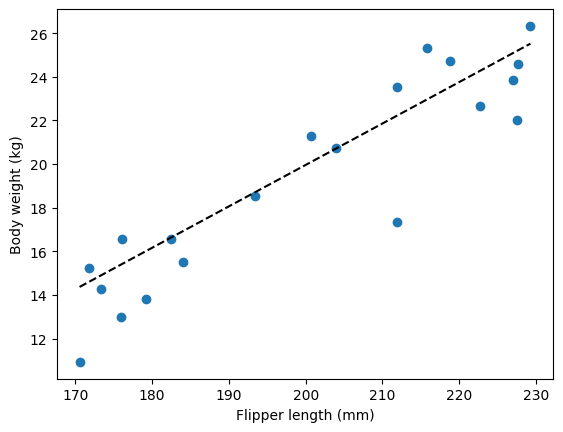

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def linear_mdl(x, beta_0, beta_1, error_mu, error_sigma):
    y = beta_0 + beta_1 * x + np.random.normal(error_mu, error_sigma, size=x.shape[0])
    return y

# Define the parameters for our simulation:
n_penguins = 20
flipper_length_mm = np.sort(np.random.uniform(170, 230, n_penguins))  # Let's say we collected the flipper length of penguins and that these are between 170 and 230mm
flipper_length_mm_center = flipper_length_mm - np.mean(flipper_length_mm)
beta_0 = 20  # Intercept
beta_1 = 0.19  # Regression coefficient between flipper length and body weight 
error_mu = 0  # Mean error term
error_sigma = 2  # Error term spread

# Simulate the data:
y = linear_mdl(flipper_length_mm_center, beta_0, beta_1, error_mu, error_sigma)

# Plot the data:
fig, ax = plt.subplots()
ax.scatter(flipper_length_mm, y)  # Plot the simulated data
ax.plot(flipper_length_mm, beta_0 + beta_1 * flipper_length_mm_center, color='k', linestyle='--', label='Regression line')  # Plot the regression line
ax.set_xlabel('Flipper length (mm)')
ax.set_ylabel('Body weight (kg)')
plt.show()
plt.close()

## Calculating the free energy
If we go back to the formulae of the free energy, we have:

$$F[Q(\Theta)] =  ln P(y, \mu) - \frac{n}{2} + \frac{1}{2} [ln(|\Sigma|) + nln2\pi e]$$

For our particular example, we need to compute the log of the joint probability $P(y, \mu)$, with $y$ being the weight of our penguins, and the joint likelihood being the product of our prior and the likelihood of the data given the specific values $\mu$, i.e. a particular combination of values for $\beta_0$, $\beta_1$ and $\sigma$. So we will implement a first function to compute this quantity. And logically, this function should take as input the data $y$, the parameters of our priors, and our guess for the values of $beta_0$, $\beta_1$ and $\sigma$, so that we can try a bunch of them to find the ones yielding the max value of the free energy functional.

We will use a couple of tricks in the code, to make it a bit more concise. The first thing to note is that because we need the log of the joint probability, we can turn multiplications into sums. If you remember, the joint probability is defined as:

$$P(y, \Theta) = P(y|\Theta)P(\Theta)$$

But since we need the log, we can instead to an addition:

$$ln(y, \Theta) = ln(P(y|\Theta)P(\Theta)) = ln(P(y|\Theta)) + ln(P(\Theta))$$

And if you remember, we used a multivariate normal distribution for the $\beta_0$ and $\beta_1$, and an inverse gamma for the $\sigma$, and the prior consists of the multiplication between the two, so we can break the formulae down even more:

$$ln(y, \Theta) = ln(P(y|\Theta)) + ln(P(\boldsymbol{\beta})) + ln(P(\sigma))$$

So we will write a function that computes each bit and then takes the sum of all. In addition, since each bit is also a log, we can simplify any multiplications within each of the formulas by using additions instead. We can write the function as:


In [43]:
import numpy as np
from scipy.special import gammaln

def log_joint(y, X, beta_prior_mu, beta_prior_sigma, alpha, lmbda, mu):
    """
    Compute ln P(y, mu) for a general linear model:
    y = X beta + e, e ~ N(0, sigma^2 I)
    
    with priors:
    beta ~ N(mu_beta, Sigma_beta)
    sigma^2 ~ Inv-Gamma(alpha, lmbda)

    Parameters
    ----------
    y : np.ndarray, shape (n,)
        Observed data vector.
    X : np.ndarray, shape (n, p)
        Design matrix (including intercept if desired).
    beta_prior_mu : np.ndarray, shape (p,)
        Prior mean vector for beta.
    beta_prior_sigma : np.ndarray, shape (p, p)
        Prior covariance matrix for beta.
    alpha : float
        Shape parameter of the inverse-gamma prior on sigma^2.
    lmbda : float
        Scale parameter (often denoted lambda) of the inverse-gamma prior on sigma^2.
    mu : np.ndarray, shape (p+1,)
        The guessed or tested mode values: [beta_0, ..., beta_{p-1}, sigma^2].

    Returns
    -------
    float
        The value of ln P(y, mu).
    """
    # Extract parameters from mu
    p = X.shape[1]
    beta = mu[:p]  
    sigma2 = mu[p]

    n = len(y)

    # 1. Log-likelihood: ln P(y|Theta)
    # y | Theta ~ N(X beta, sigma^2 I)
    # ln P(y|Theta) = -n/2 ln(2*pi*sigma2) - (1/(2*sigma2)) (y - X beta)^T (y - X beta)
    residuals = y - X.dot(beta)
    SSE = np.sum(residuals**2)
    log_lik = - (n/2)*np.log(2*np.pi*sigma2) - SSE/(2*sigma2)

    # 2. Log-prior for beta: beta ~ N(mu_beta, Sigma_beta)
    # ln P(beta) = -p/2 ln(2pi) - 1/2 ln(|Sigma_beta|)
    #              -1/2 (beta - mu_beta)^T Sigma_beta^{-1} (beta - mu_beta)
    diff = beta - beta_prior_mu
    inv_Sigma_beta = np.linalg.inv(beta_prior_sigma)
    log_prior_beta = - (p/2)*np.log(2*np.pi) \
                     - 0.5*np.log(np.linalg.det(beta_prior_sigma)) \
                     - 0.5*diff.T.dot(inv_Sigma_beta).dot(diff)

    # 3. Log-prior for sigma^2: sigma^2 ~ Inv-Gamma(alpha, lmbda)
    # P(sigma^2) = (lmbda^alpha / Gamma(alpha)) (sigma^2)^(-alpha-1) exp(-lmbda/sigma^2)
    # ln P(sigma^2) = alpha ln(lmbda) - ln Gamma(alpha) - (alpha+1)*ln(sigma^2) - lmbda/sigma^2
    log_prior_sigma2 = alpha*np.log(lmbda) - gammaln(alpha) - (alpha+1)*np.log(sigma2) - (lmbda/sigma2)

    # Combine all terms:
    # ln P(y, mu) = ln P(y|Theta) + ln P(beta) + ln P(sigma^2)
    log_joint_val = log_lik + log_prior_beta + log_prior_sigma2

    return log_joint_val


Not all that terrible, and that's actually the most difficult part of the equation. For the rest, we only need to determine the number of parameters we have based on the inputs, and calculate them. So we can in fact write the rest of the free energy functional in a single go:

In [44]:
def free_energy(y, X, beta_prior_mu, beta_prior_sigma, alpha, lmbda, mu, Sigma):
    """
    Compute the free energy F[Q(Theta)] given:

    F[Q(Theta)] = ln P(y, mu) - (n/2) + (1/2)(ln|Sigma| + n ln(2πe))

    Here n is the dimension of the parameter space, i.e. number of parameters.
    If mu includes p parameters for beta and 1 parameter for sigma^2, then n = p+1.

    Parameters
    ----------
    y : np.ndarray, shape (num_obs,)
        Observed data vector.
    X : np.ndarray, shape (num_obs, p)
        Design matrix.
    beta_prior_mu : np.ndarray, shape (p,)
        Prior mean vector for beta.
    beta_prior_sigma : np.ndarray, shape (p, p)
        Prior covariance matrix for beta.
    alpha : float
        Shape parameter of the inverse-gamma prior on sigma^2.
    lmbda : float
        Scale parameter of the inverse-gamma prior on sigma^2.
    mu : np.ndarray, shape (p+1,)
        The mode values: [beta_0, ..., beta_{p-1}, sigma^2].
    Sigma : np.ndarray, shape (p+1, p+1)
        The covariance matrix of the approximate posterior Q(Theta).

    Returns
    -------
    float
        The value of the free energy functional for these parameters.
    """
    # n is the dimension of the parameter vector mu, not the number of observations.
    n = len(mu)  # dimension of parameter space (p+1)

    # Compute ln P(y, mu)
    log_joint_val = log_joint(y, X, beta_prior_mu, beta_prior_sigma, alpha, lmbda, mu)

    # Compute log|Sigma|
    log_det_Sigma = np.log(np.linalg.det(Sigma))

    # n ln(2πe)
    term = n * np.log(2 * np.pi * np.e)

    F = log_joint_val - (n/2) + 0.5 * (log_det_Sigma + term)
    return F


We've done it! We have just applied variational Laplace to calculate the free energy! We have now fullfiled what we set ourselves to explain in this book. If you have understood everything until that point, you have basically understood the method of variational Laplace. Everything from here on will be about showing how this method can be extended to more complicated problems, such as hierarchical models, multivariate models, and eventually (maybe, if I have time) dynamical causal models. But if you've made it so far, you've got the gist of it, so congrats.

But I would encourage you to read just a little bit longer, even if you are only interested in variational Laplace in the specific case of univariate models (like our simple penguin example), because there is one last problem we need to solve to be able to really make use of the method of variational Laplace

## Maximizing free energy to find our approximate prior
With the formulae above, we can calculate the free energy. So in order to answer our question about the relationship between penguins flippers length and their weights, all we need to do is compute the free energy under as many possible combinations of $\mu$ and $\Sigma$ as we can, so that we find the one combination that yields the highest value. 

In the example above, we have simulated the data, so we actually know what the ground truth parameters are. That's quite handy, because we can start looking for combinations of $\mu$ and $\Sigma$ somewhere close by where our true parameters are. Let's give that a go:

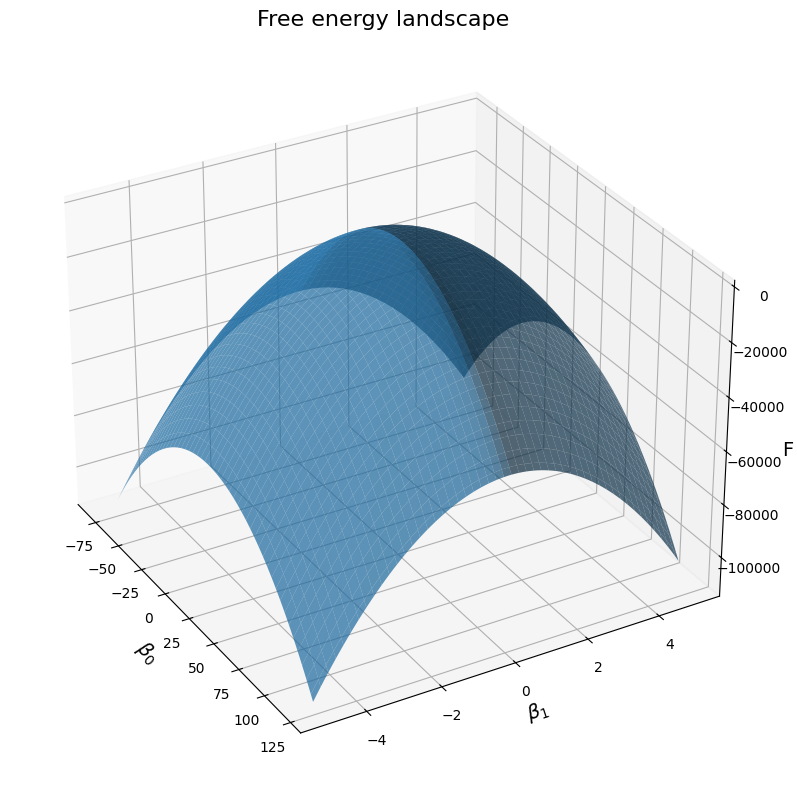

In [45]:
# Prior parameters:
beta_prior_mu = [20, 0]  # Prior belief about the mean for the beta parameters
beta_prior_sigma = [[10, 0], [0, 10]]  # Prior covariance for our beta parameters
alpha = 1  # Prior of the inverse gamma distribution for the sigma parameter
lmbda = 1  # Prior of the inverse gamma distribution for the sigma parameter

# Mu values to calculate the free energy for:
n_vals = 100
b0_vals = np.linspace(-80, 120, n_vals)  # 50 steps for beta_0
b1_vals = np.linspace(-5, 5, n_vals)    # 50 steps for beta_1
B0, B1 = np.meshgrid(b0_vals, b1_vals)
mu_sigma = 2  # Variance of the error, fixed for illustration purposes

# Sigma values to calculate the free energy for:
sigma = np.eye(3)  # An eye matrix, which is equal to [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

# Add an intercept column to the design matrix:
X = np.zeros(shape=[n_penguins, 2]) + 1
X[:, 1] = flipper_length_mm_center

# Calculate the free energy for each combinations:
F = np.zeros((n_vals, n_vals))

for i in range(n_vals):
    for j in range(n_vals):
        mu_ij = np.array([B0[i,j], B1[i,j], mu_sigma])
        F[i, j] = free_energy(y, X, beta_prior_mu, beta_prior_sigma, alpha, lmbda, mu_ij, sigma)

# Plot the free energy landscape, as a function of the two betas for illustrations' sake:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(B0, B1, F, linewidth=0, alpha=0.7)
# Customize the axes
ax.set_xlabel(r'$\beta_0$', fontsize=14)
ax.set_ylabel(r'$\beta_1$', fontsize=14)
ax.set_zlabel(r'F', fontsize=14)
ax.set_title(f'Free energy landscape', fontsize=16)
# Adjust viewing angle for better visualization
ax.view_init(elev=30, azim=-30)
plt.tight_layout()
plt.show()
plt.close()

As we can see, the free energy landscape seems to reach a single peak for a particular combination of $\beta_0$ and $\beta_1$. This makes sense: there is a single combination of the two that approximate the posterior the closest, and the further away we go from these values in both direction, the worst it becomes. Let's see what these particular values are:

In [46]:
# Find the values of beta_0 and beta_1 that maximize the free energy:
inds = np.where(F == np.max(F))
beta_0_max = B0[inds]
beta_1_max = B1[inds]
print(f"B0 = {np.round(beta_0_max, 2)}, B1 = {np.round(beta_1_max, 2)}")

B0 = [18.99], B1 = [0.15]


We are not too far off from our true values, which were $\beta_0=20$ and $\beta_1=0.19$. And in fact, an important reason why we are not closer is because of the resolution of our sampling of the parameters space. Indeed, we only took  100 values within particular intervals for each parameter, so these values are in fact the ones that are closest to the true values:

In [47]:
beta_0_max = b0_vals[inds[1] + 1]
beta_1_max = b1_vals[inds[0] + 1]
print(f"B0 = {np.round(beta_0_max, 2)}, B1 = {np.round(beta_1_max, 2)}")

B0 = [21.01], B1 = [0.25]


At this point, you may have a quite fundamental question about the appeal of Bayesian statistics. We had to go through a whole lot of math, yet it would seem that the values we get here are a whole lot similar to what we would have obtained using maximum likelihood estimates. Indeed, the fact that we get similar that are very close to the true value we use suggests that the prior doesn't really matter, since the true value used to generate the data are what seems to matter. So then what's the point? Why not compute the maximum likelihood estimate based on the data and consider that these are the means of our posterior? 

The answer is that while in this particular problem, it seems to be the same, it is not necessarily the case. The posterior distribution is always going to be sort of a middle ground between the likelihood and the posterior, because remember that it is the combination of these two parameters that determines the overall shape of the posterior, including its mode. It is then a question of *weighting* the two. The equilibrium depends on the amount of data that you have, and on the tightness of the prior. The more data you have, the heavier the likelihood is going to weight on the posterior. And the tighter the prior is, the more it is going to be reflected in the posterior. At the end of the day, it is always a question of the "tightness" of each distribution (i.e. the prior and the likelihood). A "tighter" distribution is a distributation that has a high probability distributed over a small parameter space, and the tighter a distribution is, the harder it is to nudge it in any direction when its multiplied by another distribution. The more data you have, the tighter your likelihood is, and therefore the more it weight on the posterior. And the prior can be set to whatever you like, but basically, if you have really strong reasons to believe that the true value of a parameter is within a small range, then setting a really tight prior means that it's going to be harder for you to change your mind, which also is how you would expect it to behave.

But there is still a problem with the approach I have shown above. What I said about the resolution of our sampling of the parameter space is a problem. We have picked 100 values within a range that we have defined for $\beta_0$ and $\beta_1$, that is not a whole lot. Now let's see what happens if we sample more values, let's say 500:

In [ ]:
# Mu values to calculate the free energy for:
n_vals = 500
b0_vals = np.linspace(-80, 120, n_vals)  # 50 steps for beta_0
b1_vals = np.linspace(-5, 5, n_vals)    # 50 steps for beta_1
B0, B1 = np.meshgrid(b0_vals, b1_vals)
mu_sigma = 2  # Variance of the error, fixed for illustration purposes

# Sigma values to calculate the free energy for:
sigma = np.eye(3)  # An eye matrix, which is equal to [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

# Add an intercept column to the design matrix:
X = np.zeros(shape=[n_penguins, 2]) + 1
X[:, 1] = flipper_length_mm_center

# Calculate the free energy for each combinations:
F = np.zeros((n_vals, n_vals))

for i in range(n_vals):
    for j in range(n_vals):
        mu_ij = np.array([B0[i,j], B1[i,j], mu_sigma])
        F[i, j] = free_energy(y, X, beta_prior_mu, beta_prior_sigma, alpha, lmbda, mu_ij, sigma)

# Plot the free energy landscape, as a function of the two betas for illustrations' sake:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot the surface
surf = ax.plot_surface(B0, B1, F, linewidth=0, alpha=0.7)
# Customize the axes
ax.set_xlabel(r'$\beta_0$', fontsize=14)
ax.set_ylabel(r'$\beta_1$', fontsize=14)
ax.set_zlabel(r'F', fontsize=14)
ax.set_title(f'Free energy landscape', fontsize=16)
# Adjust viewing angle for better visualization
ax.view_init(elev=30, azim=-30)
plt.tight_layout()
plt.show()
plt.close()

If you are running the code yourself, you'd have noticed that it got much slower, which makes sense given that we tried many more values. But you also noticed that we only tried different values for the $\beta$ parameters, what about the $\sigma^2$ and the covariance matrix $\Sigma$? The problem is that if we have to try many different values to find the best ones, there are already more values than we can try for a simple problem like ours. Even for a very simple linear regression, it would take hours of computation to try out enough parameters in real life applications where we don't even know where to start! And the more parameters we add, the bigger the problem becomes, because this is essentially a combinatorial problem, meaning that the amount of computation explodes when we add more and more parameters.

This is the one key issue to adress to make use of the variational approximation method that we have seen in the previous chapters. And the waz it is solved is by relying on so-called optimization methods, which enable to avoid looking at random and limit the number of computations to try. This is what we will discuss in the next section.

## Summary
Up until now, we have seen all the core aspects of the variational laplace method. What will follow is only about finding ways to make the process of maximizing the free energy functional faster, so that we can find the approximate posterior and the approximation of the model evidence faster. In principle, you can stop reading here, and you would have understood the very core of what this book is about. If that your main objective is was to understand the method to use various tools relying on it, congrats, mission achieved. When using tools that rely on this method in the future you can just think to yourself, "I know how this works, they just calculate the free energy with many different parameters until they found the ones that yield the largest value, and they probably used optimization tricks that I don't need to know about to do it fast". That's plenty enough!

However, if your goal is to actually implement variational free energy method yourself, the next section is for you, as it introduces methods of optimization that are used to find the parameters (i.e. the mode $\mu$ and the covariance $\Sigma$) faster. 

Regardless of which of the two groups you fall under (user or implementer), I encourage you to read the sections after the next one. What we have seen so far are the fundamentals: how to calculate the free energy to approximate the posterior in the simplest possible case of a linear model. This method can however be used to many more extremely useful cases, which cover:
- hierarchical models (i.e. linear mixed models)
- Multivariate models
- Dynamical causal models (DCM)

So if you are from the same background as me, what that means is that with variational Laplace, you can perform all the typical analyses that you do in your research, in a complete Bayesian framework, including decoding-like analyses. There is a just few more mathematical details to figure out in each case, but what we should get in the end is an adjusted version of the formula above that should apply to all cases at once. Sounds promising, doesn't it? 